Grid array NxM. Goal: get from start cell to goal cell (on column with strong wind, neighboring are strong too), each step yields reward of -1, undiscounted.

Actions: go to any of 4 or 8 neighboring cells or stay at your cell. Do ablation to compare with just 4 moves.

In the middle: wind, blows you up either 1 cell or 2 cells (column property).

eps-greedy Sarsa, eps=0.1, alpha=0.5, Q0=0. 80000 timesteps should be enough. Assume that wind is stochastic and can deviate by 1 from mean value in the column (even if this mean value is 0 - it can occur on any column in fact. also it can blow you downwards).

This is not intended to be an accurate Sutton-Barto 2018 Example 6.5 reproduction, there are some differences

(e.g. timing of when the environment is 'done' and wind application is different)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm, tnrange as trange
plt.style.use('dark_background')

In [68]:
def eps_greedy_policy(state, eps, q):
    n_actions = q.shape[-1]
    if np.random.binomial(n=1, p=eps):
        action_i = np.random.randint(n_actions)
    else:
        action_values = q[[[i] for i in state]]
        action_i = np.argmax(action_values)
    return action_i

In [69]:
def apply_action(state, action_i):
    '''Actions: 0 up, 1 right, 2 down, 3 left
    Possibly 4 up+right, 5 right+down, 6 down+left, 7 left+up
    Possibly 8 do nothing
    '''
    next_state = state.copy()
    if action_i == 0:
        next_state[0] -= 1
    elif action_i == 1:
        next_state[1] += 1
    elif action_i == 2:
        next_state[0] += 1
    elif action_i == 3:
        next_state[1] -= 1
    elif action_i == 4:
        next_state[0] -= 1
        next_state[1] += 1
    elif action_i == 5:
        next_state[0] += 1
        next_state[1] += 1
    elif action_i == 6:
        next_state[0] += 1
        next_state[1] -= 1
    elif action_i == 7:
        next_state[0] -= 1
        next_state[1] -= 1
    elif action_i == 8:
        pass
    else:
        raise Exception
    return next_state

In [70]:
def apply_wind(state, column_winds):
    wind_strength = column_winds[state[1]]
    next_state = state.copy()
    next_state[0] -= wind_strength
    return next_state

In [71]:
def bound_state(state, n, m):
    next_state = state.copy()
    if next_state[0] < 0:
        next_state[0] = 0
    if next_state[0] >= n:
        next_state[0] = n-1
    if next_state[1] < 0:
        next_state[1] = 0
    if next_state[1] >= m:
        next_state[1] = m-1
    return next_state

In [72]:
def step(state, action_i, apply_wind, n, m, goal_cell):
    next_state = apply_action(state, action_i)
    next_state = bound_state(next_state, n, m)
    next_state = apply_wind(next_state)
    next_state = bound_state(next_state, n, m)
    
    if np.allclose(next_state, goal_cell):
        return -1, next_state, True
    return -1, next_state, False

In [102]:
def draw_playback(experiences, n, m, goal_cell):
    playback = np.zeros((n, m))
    for i, exp in enumerate(experiences):
        state = exp[0]
        playback[state[0], state[1]] = i+1
    playback[goal_cell[0], goal_cell[1]] = i+2
    return playback

In [96]:
def train_sarsa(n, m, n_actions, eps, alpha, gamma, start_cell, goal_cell, column_winds, episodes, apply_wind=apply_wind,
                expected_sarsa=False):
    '''Maybe turn eps decay into param later
    '''
    q = np.zeros([n, m, n_actions])
    experiences = []
    episode_lens = []
    for episode_i in trange(episodes):
        cur_eps = eps * (episodes-episode_i) / episodes  # decay
        done = False
        state = start_cell
        action_i = eps_greedy_policy(state, cur_eps, q)
        episode_step = 0
        while not done:
            reward, next_state, done = step(state, action_i, lambda state: apply_wind(state, column_winds), n, m, goal_cell)
            prev_state = state
            prev_action_i = action_i
            next_action_i = eps_greedy_policy(next_state, cur_eps, q)
            # now we have: prev_state, prev_action_i, reward, next_state, next_action_i
            experiences.append((prev_state, prev_action_i, reward, next_state))
            if not expected_sarsa:
                next_q = q[next_state[0], next_state[1], next_action_i]
            else:
                next_q = (1-cur_eps) * q[next_state[0], next_state[1], next_action_i] + \
                         (cur_eps / n_actions) * q[next_state[0], next_state[1]].sum()
            q[prev_state[0], prev_state[1], prev_action_i] += \
                alpha * (reward + gamma * next_q - q[prev_state[0], prev_state[1], prev_action_i])
            state = next_state
            action_i = next_action_i
            episode_step += 1
        episode_lens.append(episode_step + 1)
    return q, episode_lens, experiences

In [97]:
def play_policy(policy, q, start_cell, goal_cell, n, m, apply_wind, column_winds):
    n_actions = q.shape[-1]
    experiences = []
    done = False
    state = start_cell
    while not done:
        action_i = policy(state, q)
        reward, next_state, done = step(state, action_i, lambda state: apply_wind(state, column_winds), n, m, goal_cell)
        experiences.append((state, action_i, reward, next_state))
        state = next_state
        if done:
            break
    return experiences

In [98]:
def play_greedy(q, start_cell, goal_cell, n, m, apply_wind, column_winds):
    policy = lambda state, q: eps_greedy_policy(state, 0, q)
    return play_policy(policy, q, start_cell, goal_cell, n, m, apply_wind, column_winds)

In [103]:
def train_show(**train_params):
    q, episode_lens, experiences = train_sarsa(**train_params)
    
    print(f'Played {len(experiences)} timesteps in {train_params["episodes"]} episodes')
    plt.figure(figsize=(12, 3))
    plt.title('Episode lengths')
    img = plt.semilogy(episode_lens)
    
    plt.figure(figsize=(6, 5))
    plt.title('State values wrt greedy policy')  # well, almost greedy. because eps was decayed!
    img = plt.imshow(q.max(axis=2))

    # will enter infinite loop if greedy policy doesn't achieve the goal
    experiences = play_greedy(q, train_params['start_cell'],
                              train_params['goal_cell'], train_params['n'], train_params['m'],
                              apply_wind, train_params['column_winds'])
    plt.figure(figsize=(6, 5))
    plt.title('Greedy policy rollout')
    img = plt.imshow(draw_playback(experiences, train_params['n'], train_params['m'], train_params['goal_cell']))
    
    return q

## Initial SARSA setup


Played 24237 timesteps in 1000 episodes


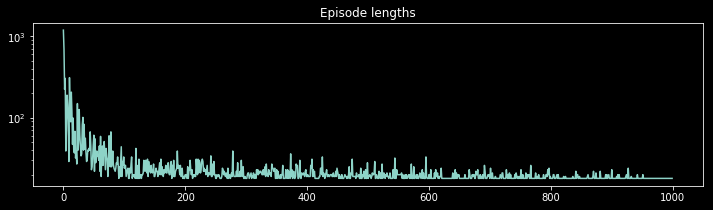

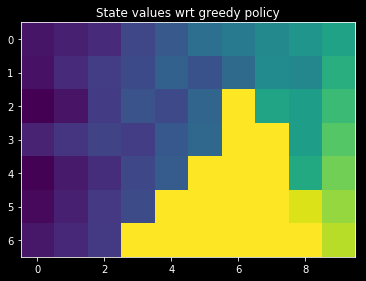

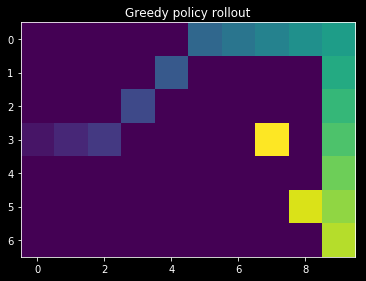

In [104]:
q = train_show(n=7, m=10, n_actions=4,
               eps=0.1, alpha=0.5, gamma=1, start_cell=np.array([3, 0]), goal_cell=np.array([3, 7]),
               column_winds=np.array((0, 0, 0, 1, 1, 1, 2, 2, 1, 0)), episodes=1000)

States visited by policy are visualized with cold colors at the beginning and warm colors in the end.

Values of many states are 0 because eps-greedy policy never went in there to explore!
Mostly because of the wind.

## Expected SARSA


Played 24670 timesteps in 1000 episodes


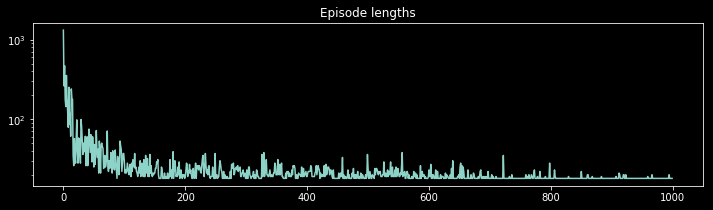

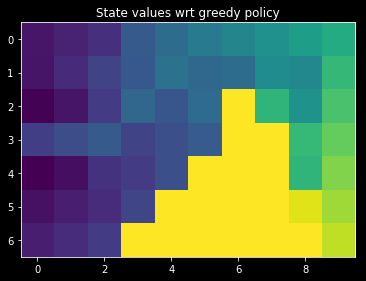

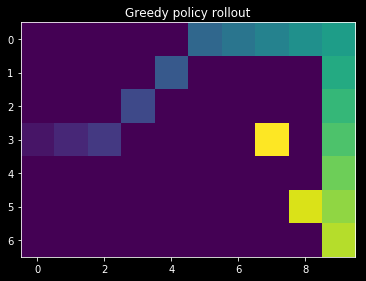

In [105]:
q = train_show(n=7, m=10, n_actions=4,
               eps=0.1, alpha=0.5, gamma=1, start_cell=np.array([3, 0]), goal_cell=np.array([3, 7]),
               column_winds=np.array((0, 0, 0, 1, 1, 1, 2, 2, 1, 0)), episodes=1000, expected_sarsa=True)

Looks really similar. Let's compare with SARSA on a finer scale. We'll only trask episode lens because rewards are constant and undiscounted.

In [106]:
outer_iters = 10
episodes = 300

In [107]:
usual_episode_lens_sum = np.zeros(episodes)
for i in range(outer_iters):
    q, episode_lens, experiences = train_sarsa(n=7, m=10, n_actions=4,
        eps=0.1, alpha=0.5, gamma=1, start_cell=np.array([3, 0]), goal_cell=np.array([3, 7]),
        column_winds=np.array((0, 0, 0, 1, 1, 1, 2, 2, 1, 0)), episodes=episodes, expected_sarsa=False)
    usual_episode_lens_sum += np.array(episode_lens)
usual_episode_lens_sum /= outer_iters

In [108]:
expected_episode_lens_sum = np.zeros(episodes)
for i in range(outer_iters):
    q, episode_lens, experiences = train_sarsa(n=7, m=10, n_actions=4,
        eps=0.1, alpha=0.5, gamma=1, start_cell=np.array([3, 0]), goal_cell=np.array([3, 7]),
        column_winds=np.array((0, 0, 0, 1, 1, 1, 2, 2, 1, 0)), episodes=episodes, expected_sarsa=True)
    expected_episode_lens_sum += np.array(episode_lens)
expected_episode_lens_sum /= outer_iters

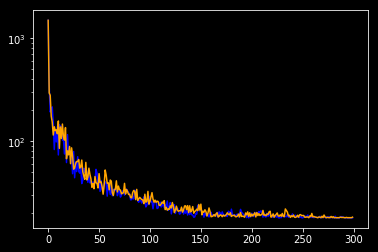

In [109]:
plt.semilogy(usual_episode_lens_sum, color='blue')
plt.semilogy(expected_episode_lens_sum, color='orange')

Exactly same convergence speed.

I will not even implement q-learning here because I expect it to have roughly the same speed of convergence on this problem.

## 8 actions


Played 47812 timesteps in 4000 episodes


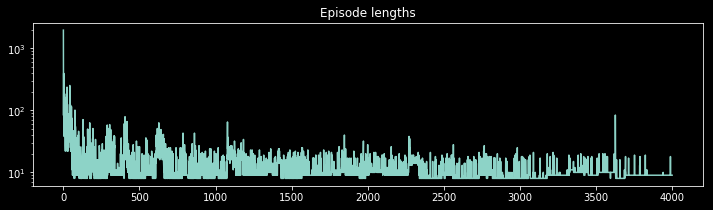

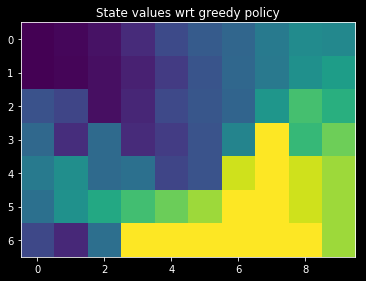

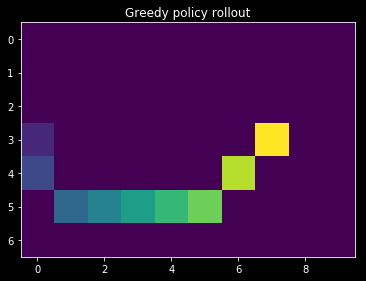

In [110]:
q = train_show(n=7, m=10, n_actions=8,
               eps=0.1, alpha=0.5, gamma=1, start_cell=np.array([3, 0]), goal_cell=np.array([3, 7]),
               column_winds=np.array((0, 0, 0, 1, 1, 1, 2, 2, 1, 0)), episodes=4000)

## 9 actions


Played 40108 timesteps in 3000 episodes


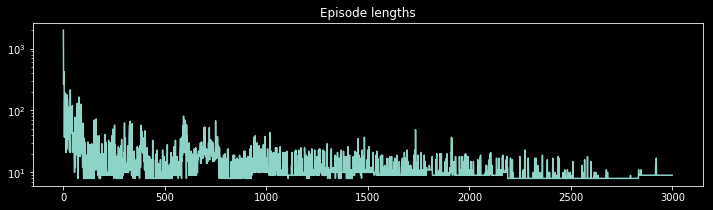

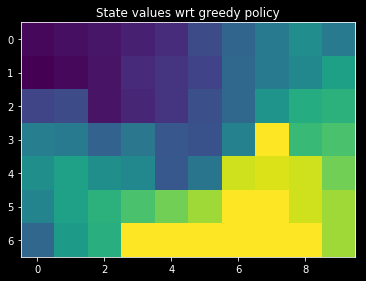

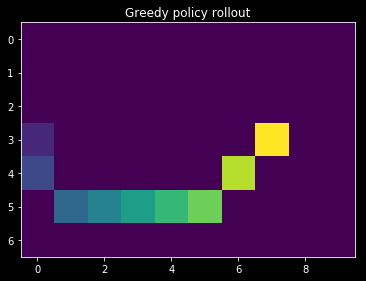

In [111]:
q = train_show(n=7, m=10, n_actions=9,
               eps=0.1, alpha=0.5, gamma=1, start_cell=np.array([3, 0]), goal_cell=np.array([3, 7]),
               column_winds=np.array((0, 0, 0, 1, 1, 1, 2, 2, 1, 0)), episodes=3000)

It's sometimes learning a policy that's a bit less effective than in the case with 8 actions for some reason. Maybe because I'm still using an eps-greedy policy and sometimes it will just do nothing on a step and be carried away by wind or something.

## Stochastic wind with 9 actions

In [114]:
def apply_stoch_wind(state, column_winds):
    wind_strength = column_winds[state[1]]
    increment = np.random.randint(-1, 2)
    wind_strength += np.random.randint(-1, 2)
    next_state = state.copy()
    next_state[0] -= wind_strength
    return next_state

In [115]:
q, episode_lens, experiences = train_sarsa(n=7, m=10, n_actions=9,
                eps=0.1, alpha=0.5, gamma=1, start_cell=np.array([3, 0]), goal_cell=np.array([3, 7]),
                column_winds=np.array((0, 0, 0, 1, 1, 1, 2, 2, 1, 0)), episodes=4000, apply_wind=apply_stoch_wind)

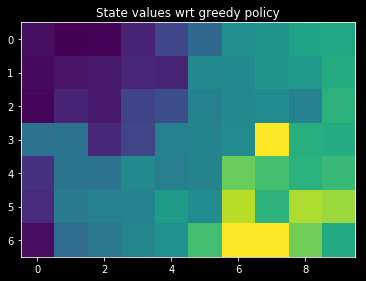

In [118]:
plt.figure(figsize=(6, 5))
plt.title('State values wrt greedy policy')
img = plt.imshow(q.max(axis=2))

Looks a bit more grim once most of it is explored because of stochasticity

Visualize several runs

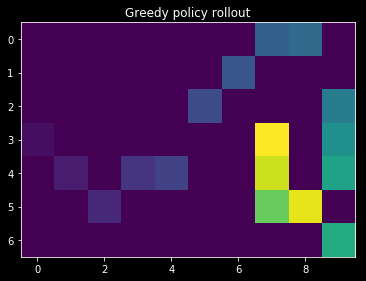

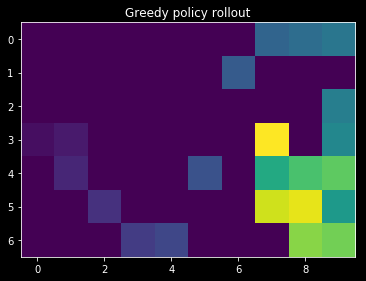

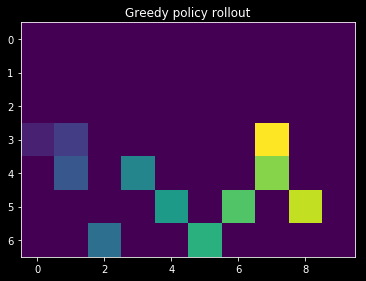

In [122]:
for i in range(3):
    experiences = play_greedy(q, start_cell=np.array([3, 0]), goal_cell=np.array([3, 7]), apply_wind=apply_stoch_wind,
                              n=7, m=10, column_winds=np.array((0, 0, 0, 1, 1, 1, 2, 2, 1, 0)))
    plt.figure(figsize=(6, 5))
    plt.title('Greedy policy rollout')
    img = plt.imshow(draw_playback(experiences, n=7, m=10, goal_cell=np.array([3, 7])))

Seems robust. But this policy run in the env without stochasticity results in an infinite loop.